# **English-to-Spanish Translation with Transformers**

## Contents

1.) Data Preprocessing
  - Downloading
  - Parsing
  - Vectorizing text into integers
  - Formatting data for training
  
2.) Implement a Transformer
  - Transformer Overview
  - `PositionalEmbedding` layer 
  - `TransformerEncoder` layer 
  - `TransformerDecoder` layer 
  - Sequence all layers together to build a `Transformer` model

3.) Train the model

4.) Inference on new English sentences

## Imports

In [1]:
import pathlib
import random
import string
import re
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.layers import TextVectorization
import pickle

tf.keras.backend.set_floatx('float64')

# 1.) Data Preprocessing

## Downloading
First, download an English-to-Spanish translation dataset
from [Anki](https://www.manythings.org/anki/).

In [2]:
text_file = keras.utils.get_file(
    fname="spa-eng.zip",
    origin="http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip",
    extract=True,
)
text_file = pathlib.Path(text_file).parent / "spa-eng" / "spa.txt"

## Parsing
Each line contains an English sentence and its corresponding Spanish sentence.
The English sentence is the *source sequence* and Spanish one is the *target sequence*.
We prepend the token `"[start]"` and we append the token `"[end]"` to the Spanish sentence.

In [3]:
with open(text_file) as f:
    lines = f.read().split("\n")[:-1]
text_pairs = []
for line in lines:
    eng, spa = line.split("\t")
    spa = "[start] " + spa + " [end]"
    text_pairs.append((eng, spa))

Print sample sentence pairs:

In [4]:
for _ in range(5):
    print(random.choice(text_pairs))

('That coin is counterfeit.', '[start] Esa moneda es falsa. [end]')
('Tom ate in the classroom with his classmates.', '[start] Tom comió en el aula con sus compañeros de clase. [end]')
('Tom and Mary took a stroll together.', '[start] Tom y María fueron juntos a caminar. [end]')
("That won't happen.", '[start] Eso no va a pasar. [end]')
('They saw me.', '[start] Me vieron. [end]')


Now, split the sentence pairs into a training set, a validation set, and a test set.

In [5]:
random.shuffle(text_pairs)

num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
num_test_samples = len(text_pairs) - num_val_samples - num_train_samples

train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples : num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples :]

print(f"{len(text_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")

118964 total pairs
83276 training pairs
17844 validation pairs
17844 test pairs


## Vectorizing Text

The English layer will use the default string standardization (strip punctuation characters) and splitting scheme (split on whitespace), while
the Spanish layer will use a custom standardization, where we add the character
`"¿"` to the set of punctuation characters to be stripped.

In [6]:
strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

vocab_size = 15000
sequence_length = 20
batch_size = 64


def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")


eng_vectorization = TextVectorization(
    max_tokens=vocab_size, output_mode="int", output_sequence_length=sequence_length,
)
spa_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)
train_eng_texts = [pair[0] for pair in train_pairs]
train_spa_texts = [pair[1] for pair in train_pairs]
eng_vectorization.adapt(train_eng_texts)
spa_vectorization.adapt(train_spa_texts)

Metal device set to: Apple M2

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2023-04-17 23:00:43.506925: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


## Formating 

At each training step, the model will seek to predict target words N+1 (and beyond) using the source sentence and the target words 0 to N.
As such, the training dataset will yield a tuple `(inputs, targets)`, where:

- `inputs` is a dictionary with the keys `encoder_inputs` and `decoder_inputs`.
`decoder_inputs` is the vectorized source sentence and `encoder_inputs` is the target sentence "so far",
that is to say, the words 0 to N used to predict word N+1 (and beyond) in the target sentence.
- `target` is the target sentence offset by one step:
it provides the next words in the target sentence -- what the model will try to predict.

In [7]:
def format_dataset(eng, spa):
    eng = eng_vectorization(eng)
    spa = spa_vectorization(spa)
    return ({"encoder_inputs": eng, "decoder_inputs": spa[:, :-1],}, spa[:, 1:])


def make_dataset(pairs):
    eng_texts, spa_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    spa_texts = list(spa_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, spa_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.shuffle(2048).prefetch(16).cache()


train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

Confirm matching sequence shapes. Note that even though our input and output shapes are identical, in theory the lengths (`shape[1]`) of the decoder inputs and target needn't match the length of the encoder inputs.

In [8]:
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")

inputs["encoder_inputs"].shape: (64, 20)
inputs["decoder_inputs"].shape: (64, 20)
targets.shape: (64, 20)


2023-04-17 23:00:48.449473: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


# 2.) Implement a Transformer


## Transfomer Overview

- The input will first be passed to an embedding layer and a position embedding layer (we merge two layers into the `PositionalEmbedding Layer`), to obtain  [embeddings](https://developers.google.com/machine-learning/glossary#embeddings) 

- Next, the input embedding of the source sequence will be passed to the `TransformerEncoder`, which will produce a new representation of it.

- This new representation will then be passed
to the `TransformerDecoder`, together with the target sequence so far (target words 0 to N). The `TransformerDecoder` will then seek to predict the next words in the target sequence (N+1 and beyond).


<img src="https://www.tensorflow.org/images/tutorials/transformer/transformer.png" width="400" alt="Transformer">

Figure 2: The Transformer architecture from  ["Attention is all you need"](https://arxiv.org/abs/1706.03762) (Vaswani et al., 2017).



### Technical details

- The Transformer's encoder and decoder consist of N layers (`num_layers`) each, containing [multi-head attention](https://developers.google.com/machine-learning/glossary#multi-head-self-attention) (`tf.keras.layers.MultiHeadAttention`) layers with M heads (`num_heads`), and point-wise feed-forward networks.
  - The encoder leverages the self-attention mechanism.
  - The decoder (with N decoder layers) attends to the encoder's output (with cross-attention to utilize the information from the encoder) and its own input (with masked self-attention) to predict the next word. The masked self-attention is causal—it is there to make sure the model can only rely on the preceding tokens in the decoding stage.

- Multi-head attention: Each multi-head attention block gets three inputs; Q (query), K (key), V (value). Instead of one single attention head, Q, K, and V are split into multiple heads because it allows the model to ["jointly attend to information from different representation subspaces at different positions"](https://arxiv.org/abs/1706.03762). You can read more about [single-head-attention](https://storrs.io/attention/) and [multi-head-attention](https://storrs.io/multihead-attention/). The equation used to calculate the self-attention weights is as follows: $$\Large{Attention(Q, K, V) = softmax_k\left(\frac{QK^T}{\sqrt{d_k}}\right) V} $$ 

<img src="https://www.tensorflow.org/images/tutorials/transformer/multi_head_attention.png" width="500" alt="multi-head attention">

Figure 3: Multi-head attention from Google Research's ["Attention is all you need"](https://arxiv.org/abs/1706.03762){:.external} (Vaswani et al., 2017).





## PositionalEncoding+Embedding Layer

We combine the text embedding and positional encoding into this layer. 

The text embedding uses a `tf.keras.layers.Embedding` layer. The positional encoding is implemented via the following formula and is added to our embedded vectors:

$$\Large{PE_{(pos, 2i)} = \sin(pos / 10000^{2i / \text{depth}})} $$
$$\Large{PE_{(pos, 2i+1)} = \cos(pos / 10000^{2i / \text{depth}})} $$

where `pos` takes value from 0 to `length - 1`, `depth` is the dimension of the embedding, and `i` takes value from `0` to `depth/2`. 


In [9]:
def positional_encoding(length, depth):
    depth = depth/2

    positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
    depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

    angle_rads = positions / ( 10000 ** depths)

    pos_encoding = np.concatenate(
        [np.sin(angle_rads), np.cos(angle_rads)],
        axis=-1) 

    return tf.cast(pos_encoding, dtype=tf.float64)


Visulaization of the `positional_encoding` function. Note the continuity w.r.t. the `Position` axis. 

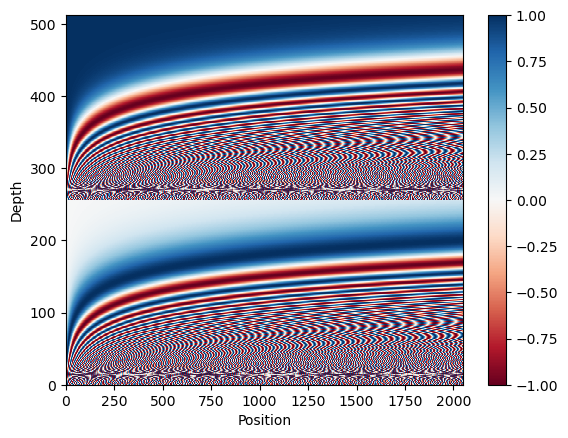

In [10]:
import matplotlib.pyplot as plt 

pos_encoding = positional_encoding(length=2048, depth=512)

# Check the shape.
assert pos_encoding.shape == (2048, 512)

# Plot the dimensions.
plt.pcolormesh(pos_encoding.numpy().T, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()


Sequence the `embedding` and `positional_encoding` together to get a `Positional Embedding Layer`. 

In [11]:
class PositionalEmbedding(layers.Layer):
    """
    Inputs of shape BxN (integer tokens)
    Outputs of shape BxNxD (embedded values)

    Applies 1.) embedding, 2.) scaling by 1/sqrt(D), 3.) pos. encoding.
    """
    def __init__(self, sequence_length, vocab_size, embed_dim):
      super().__init__()
      self.sequence_length = sequence_length
      self.embed_dim = embed_dim
      self.embedding = tf.keras.layers.Embedding(vocab_size, embed_dim, mask_zero=True) 
      self.pos_encoding = positional_encoding(length=sequence_length, depth=embed_dim)

    def compute_mask(self, *args, **kwargs):
      return self.embedding.compute_mask(*args, **kwargs)

    def call(self, x):
      length = tf.shape(x)[1]
      x = self.embedding(x)
      x *= tf.math.sqrt(tf.cast(self.embed_dim, tf.float64))
      x += self.pos_encoding[tf.newaxis, :length, :]
      return x



## TransformerEncoder Layer

This layer takes in embedded English vectors and passes them through the following layers:

* Multiheaded Self-attention
    * Attention mask:
        * The padding mask from the `PositionalEmbedding` is used to generate an attention mask in this step. This prevents training on the 0's used for padding input sentences.
* LayerNorm
* Dense (with output shape `dense_dim`)
* Dense (with output shape `embed_dim`)
* LayerNorm

with residual connections inserted before each LayerNorm.

In [12]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.feed_forward = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"), 
             layers.Dense(embed_dim, activation="relu")]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            # get padding mask via outer product of previous mask
            padding_mask = tf.map_fn(lambda x: x & tf.reshape(x, (-1,1)), mask)
        else:
            padding_mask = None
        
        
        attention_output = self.attention(query=inputs, value=inputs, key=inputs, attention_mask=padding_mask) 
        dense_input = self.layernorm_1(attention_output + inputs)
        dense_output = self.feed_forward(dense_input)
        encoder_output = self.layernorm_2(dense_input + dense_output)

        return encoder_output

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "dense_dim": self.dense_dim,
            "num_heads": self.num_heads,
        })
        return config


## TransformerDecoder Layer:

This takes in embedded Spanish vectors and passses them through the following layers:

* Multiheaded Self-attention
    * Attention mask: 
        * We implement causality via a diagonal attention mask such that 1st output word queries only the 1st input word, the 2nd word queries only the 1st and 2nd words, etc.
        * This is implemented by the `get_causal_attention_mask` function.
* LayerNorm
* Multiheaded Attention as `query`, with Encoder outputs as `key` and `value`
    * Attention mask:
        * The two padding masks from the English `Embedding` and the Spanish `Embedding` are combined in this step. This is because the two input sentences likely have different word-lengths and thus different amounts of padding.
        * This is computed outside the layer and passed in as a custom `mask` argument.
* LayerNorm
* Dense (with output shape `latent_dim`)
* Dense (with output shape `embed_dim`)
* LayerNorm

with residual connections inserted before each LayerNorm.

In [13]:
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.feed_forward = keras.Sequential(
            [layers.Dense(latent_dim, activation="relu"), 
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, padding_mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        # if mask is not None:
        #     padding_mask = mask
        #     print('padding_mask shape', padding_mask.shape)
        #     # padding_mask = tf.minimum(padding_mask, causal_mask)
        # else:
        #     padding_mask = None

        attention1_output = self.attention_1(inputs, inputs, inputs, attention_mask=causal_mask)
        attention2_queries = self.layernorm_1(inputs + attention1_output)

        attention2_output = self.attention_2(query=attention2_queries, value=encoder_outputs,
                                             key=encoder_outputs, attention_mask=padding_mask)
        ff_input = self.layernorm_2(attention2_queries + attention2_output)
   
        ff_output = self.feed_forward(ff_input)
        decoder_output = self.layernorm_3(ff_input + ff_output)

        return decoder_output 

    def get_causal_attention_mask(self, inputs):
        # Generates lower-triangular boolean tensor of shape (seq_len, seq_len).
        sequence_length = inputs.shape[-2]
        i = np.arange(sequence_length).reshape(-1,1)
        j = np.arange(sequence_length)
        return tf.constant(i >= j)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "latent_dim": self.latent_dim,
            "num_heads": self.num_heads,
        })
        return config


## Sequence layers together to make the Transformer model

We trace inputs through the model using our above Encoding and Decoding layers. Note the aforementioned computation of the decoder's padding mask `dec_mask` below.

In [14]:
#hyperparameters
embed_dim = 256
latent_dim = 2048
num_heads = 8

strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")

with tf.device('/CPU:0'):
    # encoder sequence
    enc_inputs = keras.Input(shape=(sequence_length,), dtype="int64", name="encoder_inputs")

    embedder1 = PositionalEmbedding(sequence_length, vocab_size, embed_dim)
    emb_enc_inputs = embedder1(enc_inputs)

    mask1 = embedder1.compute_mask(enc_inputs)

    encoder = TransformerEncoder(embed_dim, latent_dim, num_heads)
    enc_outputs = encoder(emb_enc_inputs, mask=mask1)

    # decoder sequence
    dec_inputs = keras.Input(shape=(sequence_length,), dtype="int64", name="decoder_inputs")

    embedder2 = PositionalEmbedding(sequence_length, vocab_size, embed_dim)
    emb_dec_inputs = embedder2(dec_inputs)

    mask2 = embedder2.compute_mask(dec_inputs)

    # padding mask for decoder computed by outer product of embedding masks
    dec_mask = mask2[:, :, tf.newaxis] & mask1[:, tf.newaxis, :]

    decoder = TransformerDecoder(embed_dim, latent_dim, num_heads)
    dec_outputs = decoder(emb_dec_inputs, enc_outputs, padding_mask=dec_mask)  # mask=dec_mask

    # final Dropout + Dense layer
    x = layers.Dropout(.5)(dec_outputs)

    transformer_output = layers.Dense(vocab_size, activation='softmax')(x)
    transformer = keras.Model([enc_inputs, dec_inputs], transformer_output, name="transformer")

transformer.summary()


Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 decoder_inputs (InputLayer)    [(None, 20)]         0           []                               
                                                                                                  
 encoder_inputs (InputLayer)    [(None, 20)]         0           []                               
                                                                                                  
 tf.math.not_equal (TFOpLambda)  (None, 20)          0           ['encoder_inputs[0][0]']         
                                                                                                  
 tf.math.not_equal_1 (TFOpLambd  (None, 20)          0           ['decoder_inputs[0][0]']         
 a)                                                                                     

# Step 3. Training our model

We'll use accuracy as a quick way to monitor training progress on the validation data. Note that machine translation typically uses BLEU scores as well as other metrics, rather than accuracy.

In [15]:
i = keras.Input((10,))
x = layers.Dense(10, activation='relu')(i)
x = layers.Dense(10, activation='relu')(x)
o = layers.Dense(10, activation='softmax')(x)
model = keras.Model(i, o)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense_5 (Dense)             (None, 10)                110       
                                                                 
 dense_6 (Dense)             (None, 10)                110       
                                                                 
 dense_7 (Dense)             (None, 10)                110       
                                                                 
Total params: 330
Trainable params: 330
Non-trainable params: 0
_________________________________________________________________


In [16]:
class Pickler(keras.callbacks.Callback):
    def __init__(self, epochs_per_pickle):
        self.epochs_per_pickle = epochs_per_pickle

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.epochs_per_pickle == 0:
            with open('trained_transformer.pickle', 'wb') as file:
                pickle.dump(transformer, file)

In [17]:
epochs = 30

with tf.device('/CPU:0'):
    transformer.compile(
        optimizer=tf.keras.optimizers.legacy.Adam(), 
        loss=tf.keras.losses.SparseCategoricalCrossentropy(ignore_class=0), 
        metrics=["accuracy"]
    )
    history = transformer.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=[Pickler(2)])


Epoch 1/30
1302/1302 [==============================] - 1293s 992ms/step - loss: 5.0377 - accuracy: 0.2134 - val_loss: 4.1271 - val_accuracy: 0.2755
Epoch 2/30
1302/1302 [==============================] - 1330s 1s/step - loss: 3.9921 - accuracy: 0.3050 - val_loss: 3.4864 - val_accuracy: 0.3483
Epoch 3/30
1302/1302 [==============================] - 1353s 1s/step - loss: 3.4011 - accuracy: 0.3697 - val_loss: 2.9958 - val_accuracy: 0.4106
Epoch 4/30
1302/1302 [==============================] - 1359s 1s/step - loss: 2.9154 - accuracy: 0.4272 - val_loss: 2.6328 - val_accuracy: 0.4603
Epoch 5/30
1302/1302 [==============================] - 1333s 1s/step - loss: 2.5432 - accuracy: 0.4714 - val_loss: 2.3843 - val_accuracy: 0.4919
Epoch 6/30
1302/1302 [==============================] - 1321s 1s/step - loss: 2.2601 - accuracy: 0.5049 - val_loss: 2.2102 - val_accuracy: 0.5143
Epoch 7/30
1302/1302 [==============================] - 1282s 984ms/step - loss: 2.0460 - accuracy: 0.5298 - val_loss: 2.

# **Inference on New Sentences** 
## Decoding test sentences

To use the translator, feed into the transformer the vectorized English sentence as well as the target token `"[start]"`, then we repeatedly generated the next token, until
we hit the token `"[end]"`.

In [18]:
spa_vocab = spa_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
max_decoded_sentence_length = 20

def decode_sequence(input_sentence):
    tokenized_input_sentence = eng_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = spa_vectorization([decoded_sentence])[:, :-1]

        probs = transformer([tokenized_input_sentence, tokenized_target_sentence])
        sampled_token_index = np.argmax(probs, axis=2)[0, i]
        
        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
            break
    return decoded_sentence

These sentences are drawn from the test set, so the transformer has never seen them before! It is still able to capture the sentences' meanings and provide some pretty good translations:

In [27]:
test_eng_texts = random.sample([pair[0] for pair in test_pairs], 20)
max_len = max([len(sentence) for sentence in test_eng_texts])

print('{a:<{field_size}}'.format(a='English Sentences:', field_size=max_len+4) + 'Spanish Translation:\n')
for sentence in test_eng_texts:
    translated = decode_sequence(sentence)
    print("{sentence: <{field_size}}   {translated}".format(sentence=sentence, field_size=max_len+1, translated=translated))

English Sentences:                                            Spanish Translation:

It's not that easy to learn a new language after fifty.       [start] no es tan fácil aprender a aprender un idioma a cincuenta metros de cincuenta metros que no cincuenta metros [end]
I began to be afraid you would never come back again.         [start] comencé a ser asustado de que nunca vuelva a volver a volver a volver a volver a volver a volver
A foreign language cannot be mastered in a year or so.        [start] un idioma extranjero no puede ser año [end]
Tom actually apologized to Mary.                              [start] tom realmente se disculpó con mary [end]
I like the melody of this song.                               [start] me gusta la melodía de esta canción [end]
A bridge gives access to the island.                          [start] un puente para la isla [UNK] [end]
Tom didn't understand anything.                               [start] tom no entendió nada [end]
Tom paid for the tickets.

In [25]:
transformer.save('trained_transformer')

INFO:tensorflow:Assets written to: trained_transformer/assets


INFO:tensorflow:Assets written to: trained_transformer/assets
